In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
from skimage.color import rgb2gray
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuration
IMG_SIZE = (64, 64)  
DATA_ROOT = '/kaggle/input/doggai/dogs-vs-cats (1)'
TRAIN_DIR = os.path.join(DATA_ROOT, 'train', 'train')

In [3]:
# Feature Extraction Functions
def extract_hog_features(img, img_size):
    """Enhanced HOG feature extraction with better parameters"""
    try:
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        img = cv2.resize(img, img_size)
        
        # HOG parameters
        features = hog(img, 
                      orientations=9, 
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),  
                      block_norm='L2-Hys',
                      transform_sqrt=True,
                      feature_vector=True)
        return features
    except Exception as e:
        print(f"Error in HOG extraction: {e}")
        return None

def extract_lbp_features(img, img_size):
    """Local Binary Pattern features for texture analysis"""
    try:
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        img = cv2.resize(img, img_size)
        
        # LBP parameters
        radius = 3
        n_points = 8 * radius
        
        lbp = local_binary_pattern(img, n_points, radius, method='uniform')
        
        # Create histogram of LBP patterns
        n_bins = n_points + 2
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
        
        # Normalize histogram
        hist = hist.astype(float)
        hist /= (hist.sum() + 1e-7)
        
        return hist
    except Exception as e:
        print(f"Error in LBP extraction: {e}")
        return None

def extract_gabor_features(img, img_size):
    """Gabor filter features for texture and edge detection"""
    try:
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        img = cv2.resize(img, img_size)
        
        # Gabor filter parameters
        frequencies = [0.1, 0.3, 0.5]
        angles = [0, 45, 90, 135]
        
        features = []
        for freq in frequencies:
            for angle in angles:
                filt_real, _ = gabor(img, frequency=freq, theta=np.deg2rad(angle))
                features.extend([
                    np.mean(filt_real),
                    np.std(filt_real),
                    np.var(filt_real),
                    np.max(filt_real),
                    np.min(filt_real)
                ])
        
        return np.array(features)
    except Exception as e:
        print(f"Error in Gabor extraction: {e}")
        return None

def extract_color_features(img, img_size):
    """Color-based features from different color spaces"""
    try:
        img = cv2.resize(img, img_size)
        
        # Convert to different color spaces
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        
        features = []
        
        # RGB channel statistics
        for channel in range(3):
            channel_data = img[:, :, channel]
            features.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.var(channel_data)
            ])
        
        # HSV channel statistics
        for channel in range(3):
            channel_data = hsv[:, :, channel]
            features.extend([
                np.mean(channel_data),
                np.std(channel_data)
            ])
        
        # LAB channel statistics
        for channel in range(3):
            channel_data = lab[:, :, channel]
            features.extend([
                np.mean(channel_data),
                np.std(channel_data)
            ])
        
        return np.array(features)
    except Exception as e:
        print(f"Error in color extraction: {e}")
        return None

def extract_combined_features(image_path, img_size):
    """Combine multiple feature extraction methods"""
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"DEBUG: Failed to read {image_path}")
            return None
        
        # Extract different types of features
        hog_features = extract_hog_features(img, img_size)
        lbp_features = extract_lbp_features(img, img_size)
        gabor_features = extract_gabor_features(img, img_size)
        color_features = extract_color_features(img, img_size)
        
        # Combine all features
        all_features = []
        if hog_features is not None:
            all_features.extend(hog_features)
        if lbp_features is not None:
            all_features.extend(lbp_features)
        if gabor_features is not None:
            all_features.extend(gabor_features)
        if color_features is not None:
            all_features.extend(color_features)
        
        return np.array(all_features) if all_features else None
        
    except Exception as e:
        print(f"DEBUG: Error reading {image_path}: {e}")
        return None

In [4]:
# --- Enhanced Data Loader ---
def load_dataset(data_dir, img_size, feature_extractor_func, limit_images=None):
    features, labels = [], []
    if not os.path.exists(data_dir):
        print(f"ERROR: Directory not found: {data_dir}")
        return np.array(features), np.array(labels)

    image_files = [f for f in os.listdir(data_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if limit_images:
        image_files = image_files[:limit_images]

    for image_name in tqdm(image_files, desc="Extracting features"):
        image_path = os.path.join(data_dir, image_name)

        if image_name.startswith('cat'):
            label = 0
        elif image_name.startswith('dog'):
            label = 1
        else:
            continue  

        features_vec = feature_extractor_func(image_path, img_size)
        if features_vec is not None:
            features.append(features_vec)
            labels.append(label)

    print(f"Loaded {len(features)} samples. Cats: {labels.count(0)}, Dogs: {labels.count(1)}")
    return np.array(features), np.array(labels)

In [5]:
# Load Dataset 
print("Loading and extracting enhanced features...")
X, y = load_dataset(TRAIN_DIR, IMG_SIZE, extract_combined_features, limit_images=10000)

if X.size == 0:
    print("ERROR: No features extracted. Check dataset path.")
    exit()

Loading and extracting enhanced features...


Extracting features: 100%|██████████| 10000/10000 [28:24<00:00,  5.87it/s]


Loaded 10000 samples. Cats: 4980, Dogs: 5020


In [6]:
# Feature Scaling
print("Applying feature scaling...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA: Dimensionality Reduction
print("Applying PCA...")
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA reduced feature shape: {X_pca.shape}")

Applying feature scaling...
Applying PCA...
PCA reduced feature shape: (10000, 521)


In [7]:
# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(
    X_pca, y, test_size=0.25, random_state=42, stratify=y)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}")

# --- Optimized Model Training with Ensemble ---
print("Training optimized models...")

# 1. SVM with streamlined parameters (much faster)
print("Training SVM with optimized parameters...")
svm_param_grid = {
    'C': [1, 10, 100],  
    'gamma': ['scale', 0.01, 0.1],  
    'kernel': ['rbf']  
}

svm_model = SVC(random_state=42, probability=True)
svm_grid = GridSearchCV(svm_model, svm_param_grid, cv=3, n_jobs=-1,  
                       verbose=1, scoring='accuracy')
svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_

print(f"Best SVM Parameters: {svm_grid.best_params_}")
print(f"Best SVM CV Accuracy: {svm_grid.best_score_:.4f}")

Train size: 7500, Validation size: 2500
Training optimized models...
Training SVM with optimized parameters...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM CV Accuracy: 0.7723


In [8]:
# 2. Random Forest with optimized parameters
print("Training Random Forest...")
rf_param_grid = {
    'n_estimators': [100, 200],  
    'max_depth': [20, 30],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2]  
}

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=3, n_jobs=-1,  
                      verbose=1, scoring='accuracy')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

print(f"Best RF Parameters: {rf_grid.best_params_}")
print(f"Best RF CV Accuracy: {rf_grid.best_score_:.4f}")

Training Random Forest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best RF Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best RF CV Accuracy: 0.7117


In [9]:
# 3. Pre-tuned models 
print("Training pre-tuned models as backup...")
# model parameters 
svm_fast = SVC(C=10, gamma='scale', kernel='rbf', random_state=42, probability=True)
rf_fast = RandomForestClassifier(n_estimators=200, max_depth=30, min_samples_split=2, 
                                min_samples_leaf=1, random_state=42, n_jobs=-1)

svm_fast.fit(X_train, y_train)
rf_fast.fit(X_train, y_train)

# Use grid search results if available, otherwise use fast models
try:
    final_svm = best_svm
    final_rf = best_rf
    print("Using grid search optimized models.")
except:
    final_svm = svm_fast
    final_rf = rf_fast
    print("Using pre-tuned models (grid search skipped).")

Training pre-tuned models as backup...
Using grid search optimized models.


In [10]:
# 4. Ensemble Model
print("Creating ensemble model...")
ensemble_model = VotingClassifier(
    estimators=[
        ('svm', final_svm),
        ('rf', final_rf)
    ],
    voting='soft'
)

ensemble_model.fit(X_train, y_train)
print("Ensemble model training completed!")

Creating ensemble model...
Ensemble model training completed!


In [11]:
# Model Evaluation
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n--- {model_name} Performance ---")
    print(f"Validation Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Predicted Cat', 'Predicted Dog'],
                yticklabels=['Actual Cat', 'Actual Dog'])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    return accuracy


--- SVM Performance ---
Validation Accuracy: 0.7756

Classification Report:
              precision    recall  f1-score   support

         Cat       0.77      0.78      0.78      1245
         Dog       0.78      0.77      0.78      1255

    accuracy                           0.78      2500
   macro avg       0.78      0.78      0.78      2500
weighted avg       0.78      0.78      0.78      2500



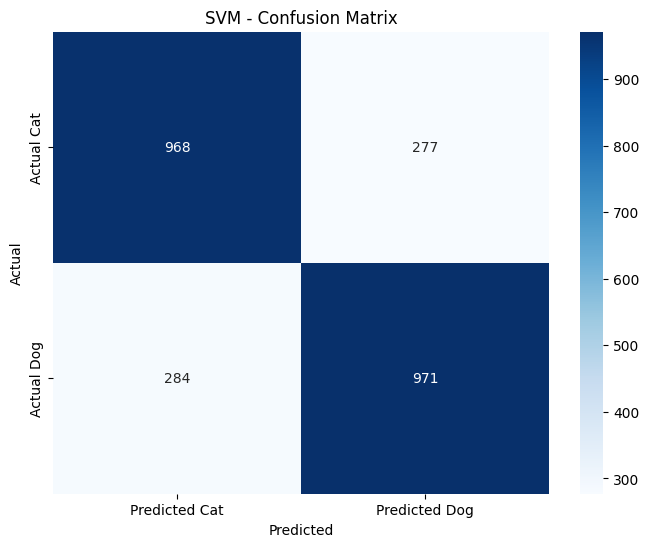


--- Random Forest Performance ---
Validation Accuracy: 0.7068

Classification Report:
              precision    recall  f1-score   support

         Cat       0.70      0.73      0.71      1245
         Dog       0.72      0.68      0.70      1255

    accuracy                           0.71      2500
   macro avg       0.71      0.71      0.71      2500
weighted avg       0.71      0.71      0.71      2500



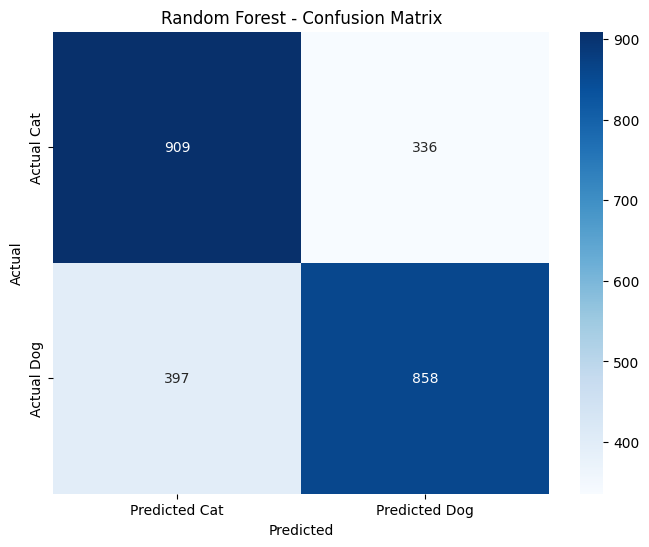


--- Ensemble Performance ---
Validation Accuracy: 0.7784

Classification Report:
              precision    recall  f1-score   support

         Cat       0.78      0.78      0.78      1245
         Dog       0.78      0.78      0.78      1255

    accuracy                           0.78      2500
   macro avg       0.78      0.78      0.78      2500
weighted avg       0.78      0.78      0.78      2500



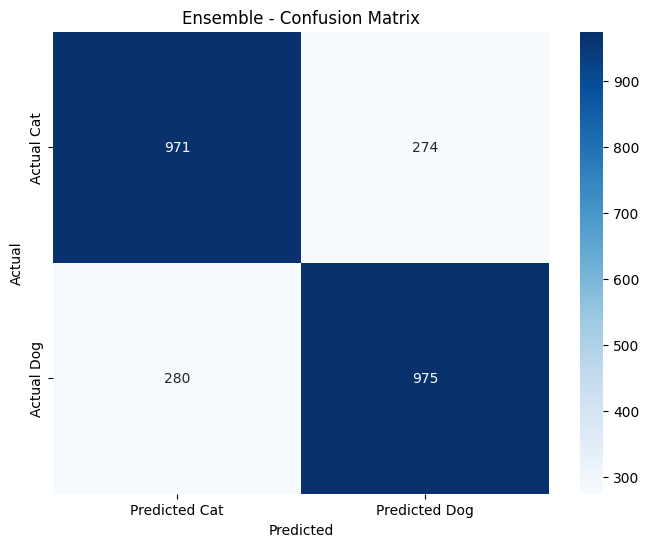


Best model achieved 0.7784 accuracy


In [12]:
# Evaluate all models
svm_acc = evaluate_model(final_svm, X_val, y_val, "SVM")
rf_acc = evaluate_model(final_rf, X_val, y_val, "Random Forest")
ensemble_acc = evaluate_model(ensemble_model, X_val, y_val, "Ensemble")

# Choose the best model
best_model = ensemble_model
best_accuracy = ensemble_acc

if svm_acc > ensemble_acc:
    best_model = final_svm
    best_accuracy = svm_acc
if rf_acc > max(ensemble_acc, svm_acc):
    best_model = final_rf
    best_accuracy = rf_acc

print(f"\nBest model achieved {best_accuracy:.4f} accuracy")


=== Batch Prediction System ===
Predicting predefined images...



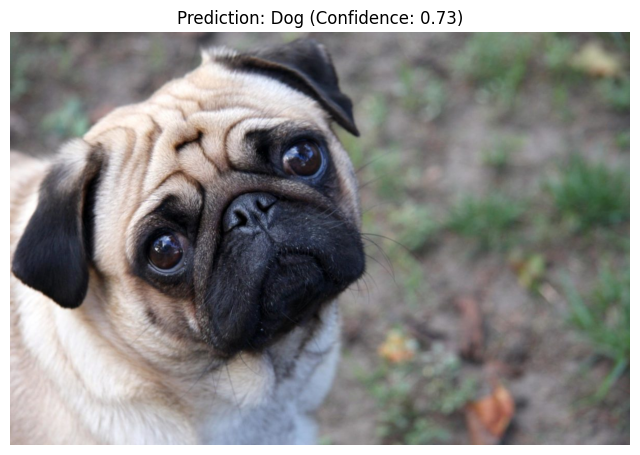

Image: dog-breeds-for-kids-pug-dog-1200x800.jpg
Prediction: Dog
Confidence: 0.73



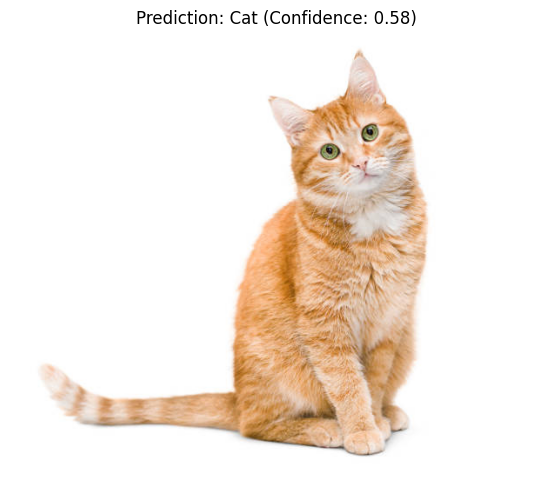

Image: istockphoto-1443562748-612x612.jpg
Prediction: Cat
Confidence: 0.58



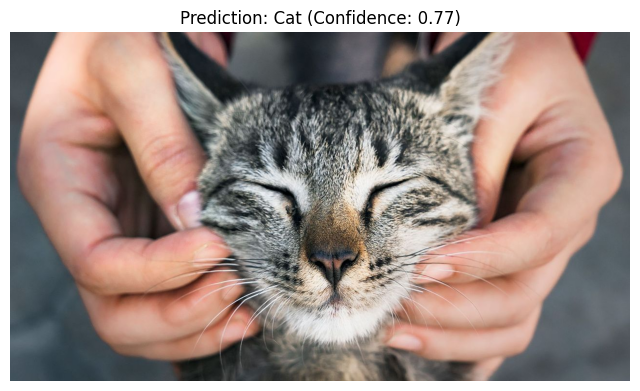

Image: p07ryyyj.jpg
Prediction: Cat
Confidence: 0.77



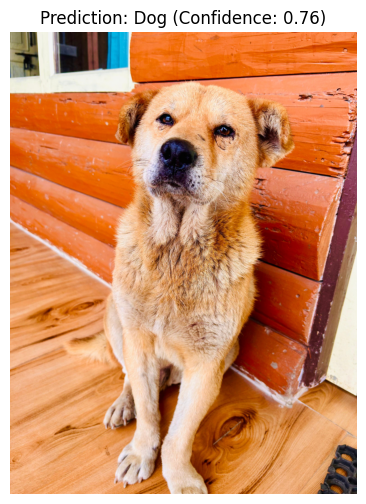

Image: 53447a5c-f588-4c3e-8116-67e5f49953df.jpg
Prediction: Dog
Confidence: 0.76



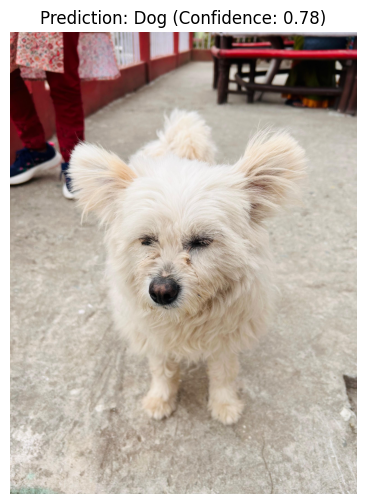

Image: 922834aa-1bb7-412f-b883-6d806fa8b165.jpg
Prediction: Dog
Confidence: 0.78



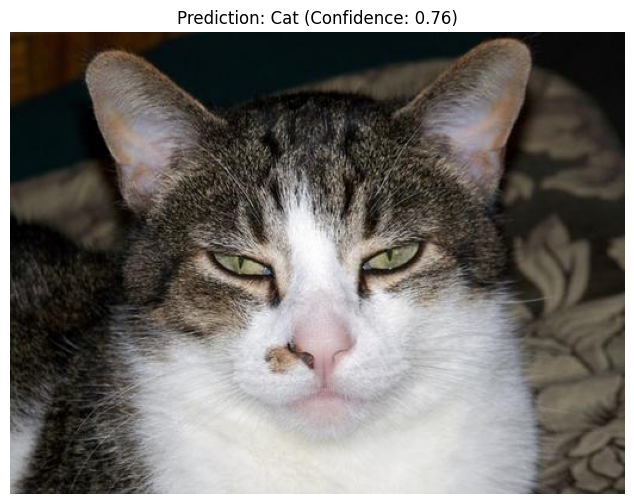

Image: cat_196542.jpg
Prediction: Cat
Confidence: 0.76



In [13]:
test_image_paths = [
    "/kaggle/input/test-dog-cat/dog-breeds-for-kids-pug-dog-1200x800.jpg",
    "/kaggle/input/test-dog-cat/istockphoto-1443562748-612x612.jpg",
    "/kaggle/input/test-dog-cat/p07ryyyj.jpg",
    "/kaggle/input/test-dog-cat/53447a5c-f588-4c3e-8116-67e5f49953df.jpg",
    "/kaggle/input/test-dog-cat/922834aa-1bb7-412f-b883-6d806fa8b165.jpg",
    "/kaggle/input/test-dog-cat/cat_196542.jpg"
]

# Prediction Function
def predict_user_image(model, pca_model, scaler, image_path, img_size, feature_extractor_func):
    """Enhanced prediction function with proper preprocessing"""
    extracted_features = feature_extractor_func(image_path, img_size)
    
    if extracted_features is not None:
      
        features_reshaped = extracted_features.reshape(1, -1)
        
        
        features_scaled = scaler.transform(features_reshaped)
        features_pca = pca_model.transform(features_scaled)
        
        prediction = model.predict(features_pca)[0]
        
        # Get prediction probability for confidence
        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(features_pca)[0]
            confidence = max(probabilities)
            return ("Cat" if prediction == 0 else "Dog"), confidence
        else:
            return ("Cat" if prediction == 0 else "Dog"), 1.0
    else:
        return "Error: Could not process image or extract features.", 0.0

# Batch Prediction 
print("\n=== Batch Prediction System ===")
print("Predicting predefined images...\n")

for user_image_path in test_image_paths:
    if not os.path.exists(user_image_path):
        print(f"File not found: {user_image_path}")
        continue

    try:
        # Load and display image
        display_img = cv2.imread(user_image_path)
        if display_img is None:
            print(f"Could not read image file: {user_image_path}")
            continue
        display_img_rgb = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)

        # Make prediction
        prediction, confidence = predict_user_image(
            best_model, pca, scaler, user_image_path, IMG_SIZE, extract_combined_features
        )

        # Show result
        plt.figure(figsize=(8, 6))
        plt.imshow(display_img_rgb)
        plt.title(f"Prediction: {prediction} (Confidence: {confidence:.2f})")
        plt.axis('off')
        plt.show()

        print(f"Image: {os.path.basename(user_image_path)}")
        print(f"Prediction: {prediction}")
        print(f"Confidence: {confidence:.2f}\n")

    except Exception as e:
        print(f"Error processing {user_image_path}: {e}")
